### Import

In [1]:
!pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import os
from tqdm import tqdm
import gc
# plot
import matplotlib.pyplot as plt

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler
from collections import OrderedDict

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


### Dataset

In [7]:
class dataset(Dataset):
    def __init__(self, root, traintest) -> None:
      super().__init__()
      self.root = root
      self.training_set = []
      if traintest == "train":
        for i, camera in enumerate(os.listdir(root)):
          images = np.load(root + camera)
          images_len = len(images)
          for image in images[:int(images_len*0.6)]:
            information = {
              'image':torch.tensor(image),
              'target':torch.tensor(i)#int(camera.split('.')[0].split('_')[2]))
              }
            self.training_set.append(information)
      elif traintest == "val":
          for i, camera in enumerate(os.listdir(root)):
            images = np.load(root + camera)
            images_len = len(images)
            for image in images[int(images_len*0.6):int(images_len*0.8)]:
              information = {
                'image':torch.tensor(image),
                'target':torch.tensor(i)#int(camera.split('.')[0].split('_')[2]))
                }
              self.training_set.append(information) 
              
      elif traintest == "test":
        for i, camera in enumerate(os.listdir(root)):
          images = np.load(root + camera)
          images_len = len(images)
          for image in images[int(images_len*0.8):]:
            information = {
              'image':torch.tensor(image),
              'target':torch.tensor(i)#int(camera.split('.')[0].split('_')[2]))
              }
            self.training_set.append(information)
    def __getitem__(self, index):
      return self.training_set[index]
    
    def __len__(self):
      return len(self.training_set)
    
    def get_labels(self):
      return [int(item['target']) for item in self.training_set]

In [8]:
root = '/content/drive/MyDrive/data/'
training_set = dataset(root, 'train')
train_dataloader = DataLoader(training_set, batch_size=4, sampler=ImbalancedDatasetSampler(training_set))
val_set = dataset(root, 'val')
val_dataloader = DataLoader(val_set, batch_size=4, sampler=ImbalancedDatasetSampler(val_set))
test_set = dataset(root, 'test')
test_dataloader = DataLoader(test_set, batch_size=4, sampler=ImbalancedDatasetSampler(test_set))

In [9]:
len(train_dataloader)

361

### Classfication

In [10]:
class classifier_model(nn.Module):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.conv1 =  torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv2 =  torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        self.pool1 =  torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.7)
        
        self.conv3 =  torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv4 =  torch.nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc1 = torch.nn.Linear(in_features=2304, out_features=256, bias=True)
        self.fc2 = torch.nn.Linear(in_features=256, out_features=10, bias=True)
        #self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
classifier = classifier_model().to(device)

In [12]:
optimizer = optim.SGD(classifier.parameters(),lr=0.001, momentum=0.5)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

In [13]:
def train(model, train_dataloader, optimizer, loss_fn, epoch):
    model.train()
    loss_total = 0
    count = 0
    for i, data in enumerate(train_dataloader):
      image = data['image'].type(torch.FloatTensor)
      #print(image)
      image = image.permute(0, 3, 2, 1)
      image = image.to(device)
      target = data['target'].to(device)

      optimizer.zero_grad()
      output = model(image)
      # pred = nn.Softmax(dim=1)(output)
      # print(pred.argmax(1))
      loss = loss_fn(output, target)
      loss.backward()

      optimizer.step()
      loss_total += loss.item()
      count += 1
        

    print(f"Train: Epoch {epoch:3d}  | loss:   {loss_total/count:8.3f}")
    return loss_total/count

In [14]:
def val(model, train_dataloader, optimizer, loss_fn, epoch):
    model.eval()
    loss_total = 0
    count = 0
    for i, data in enumerate(train_dataloader):
      image = data['image'].type(torch.FloatTensor)
      #print(image)
      image = image.permute(0, 3, 2, 1)
      image = image.to(device)
      target = data['target'].to(device)

      output = model(image)
      pred = nn.Softmax(dim=1)(output)
      # print('pred:', pred.argmax(1))
      # print('target', target)
      loss = loss_fn(output, target)
      loss_total += loss.item()
      count += 1
        

    print(f"Val:    Epoch {epoch:3d}  | loss: {loss_total/count:8.3f}")
    return loss_total/count

In [15]:
learning_rate = 0.001

In [ ]:
EPOCH = 8000
loss = []
for epoch in tqdm(range(EPOCH)):
  ls = train(classifier, train_dataloader, optimizer, loss_fn, epoch)
  loss.append(ls)
  if epoch%10 == 0:
    lv = val(classifier, val_dataloader, optimizer, loss_fn, epoch)
    if lv < 0.1:
      break

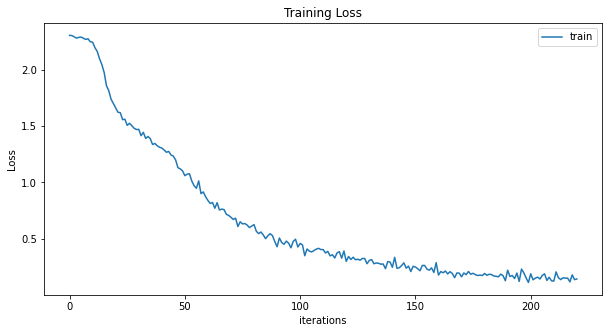

In [17]:
import matplotlib.pyplot as plt
val_losses = []
train_losses = []
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot([item for item in loss], label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

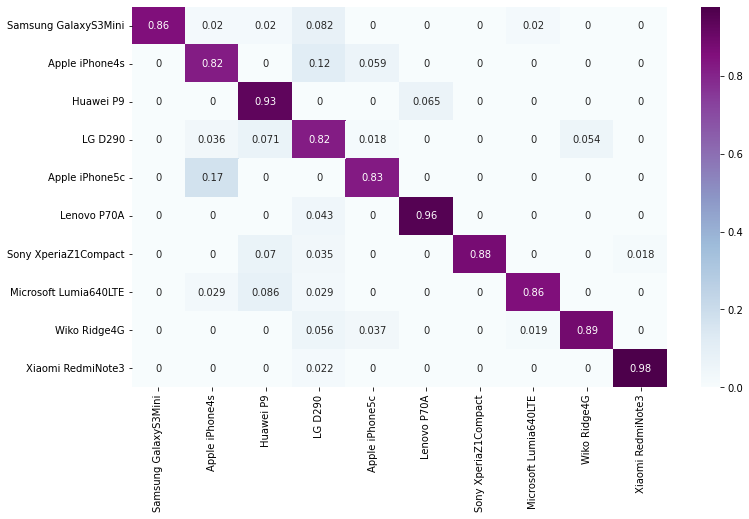

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for i, data in enumerate(test_dataloader):
  image = data['image'].type(torch.FloatTensor)
  image = image.permute(0, 3, 2, 1)
  image = image.to(device)
  target = data['target'].to(device)
  output = classifier(image)

  #output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  #y_pred.extend(output) # Save Prediction
  pred = nn.Softmax(dim=1)(output).argmax(1).data.cpu().numpy()
  y_pred.extend(pred)
  labels = target.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Samsung GalaxyS3Mini', 'Apple iPhone4s', 'Huawei P9', 'LG D290', 'Apple iPhone5c', 
      'Lenovo P70A', 'Sony XperiaZ1Compact', 'Microsoft Lumia640LTE', 'Wiko Ridge4G', 'Xiaomi RedmiNote3')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true' )
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")
plt.savefig('output.png')

In [23]:
def test(model, test_dataloader):
    model.eval()
    correct = 0
    for i, data in enumerate(test_dataloader):
      image = data['image'].type(torch.FloatTensor)
      image = image.permute(0, 3, 2, 1)
      image = image.to(device)
      target = data['target'].to(device)
      output = model(image)
      pred = nn.Softmax(dim=1)(output)
      #print(pred.argmax(1))
      correct += (pred.argmax(1) == target).type(torch.float).sum().item()

    
    print(f'accurency = {correct}/{len(test_dataloader)*4} = {correct/(len(test_dataloader)*4)}')

In [24]:
test(classifier, test_dataloader)

accurency = 451.0/488 = 0.9241803278688525
